# Open weather Map https://openweathermap.org/api

- Get API access key by subscribing to OpenWeatherMap website
- Make a multi-threaded program to connect to API. Locations to be monitored should be placed in configuration file
- One thread to download 5 days/3 hour forecast
- One thread to download weather maps
- All data should be stored in database (mongodb) as seperate collections/table
- One thread to open the latest weather map and display the map in window (should show last image as per last time stamp)
- Forecast threads should print out alerts if there is rain/snow or freeezing temperatures (<2 degree Fahrenheit) in any of forecast period
- Display forecast/previous data from database as a graph

## Required Modules

In [126]:
import requests
import json
import threading
import matplotlib.pyplot as plt
from pymongo import MongoClient
import import_ipynb
import config
import cv2
import os

## Importing the Location Data from the Config folder 

In [127]:
with open("config.json",'r') as f:
    city_list = json.load(f)

In [128]:
city_list['cities']

['Delhi', 'London', 'Utah']

## API Call for the Call 5 day / 3 hour forecast data


In [129]:
base_url = "http://api.openweathermap.org/data/2.5/forecast"
api_key = "03def23f4f250867fa0abb2f5c7ab004"
# complete_url = base_url + "?q=" + city_name +"&appid=" + api_key 

In [130]:
complete_url = base_url + "?q=" +'Delhi' +"&appid=" + api_key 

# get method of requests module 
# return response object 
response = requests.get(complete_url)

print("Converting Data from json format to python...... ")
python_format = response.json()


Converting Data from json format to python...... 


## Establishing Connection with MongoDB

In [131]:
try:  
    conn = MongoClient() 
    print("Connected successfully!!!") 

except:   
    print("Could not connect to MongoDB") 


Connected successfully!!!


In [132]:
# database 
db = conn.database 

# Created or Switched to collection names: my_gfg_collection 
collection = db.my_gfg_collection 

In [133]:
extreme_conditions = ["Rain","snow"]        

## Thread for 5 days 3 hour forecast

In [134]:
def download_5_day_forecast():
    
    #Api Call from OPenweathermap
    for city in city_list['cities']:

        print("{: ^50s}".format(city))
        complete_url = base_url + "?q=" + city +"&appid=" + api_key 

        # get method of requests module 
        # return response object 
        response = requests.get(complete_url)
        python_format = response.json()
        
        a_dict = {'City_name': python_format["city"]["name"],
         'MyForecast': python_format["list"]}
        rec_id1 = collection.insert_one(a_dict) 
        
        print("inserted_ids: ",rec_id1.inserted_id,"\n")
        
        myquery = { "_id":rec_id1.inserted_id}

        # Printing the data inserted 
        cursor = collection.find(myquery) 
        temp_read,dates =[],[]

        for record in cursor:    
            for i in record['MyForecast']: 
               temp = (i['main']['temp'])
               temp_farenheit = 1.8 * (temp - 273) + 32
               temp_read.append(temp_farenheit)
               dates.append(i['dt_txt'])
               if temp_farenheit < 2:
                    print('[ALERT]: Freezing temperature on {}'
                          .format(i['dt_txt']))         
               if i['weather'][0]['main'] in extreme_conditions:
                    print("Forecast for {} is observed to be {} on {}".format(city,i['weather'][0]['main'],i['dt_txt']))

        plt.plot(dates,temp_read)
        plt.xticks(dates, dates, rotation=90)
        plt.tick_params(axis='x', which='major', labelsize=5)
        plt.title("Forecast of Temperatures in {}".format(city))
        plt.xlabel("Date and time")
        plt.ylabel("Temperature(F)")
        plt.show()

## Thread for the weather map

In [143]:
def get_map_for_city():
    layers = ["temp_new","wind_new","pressure_new","precipitation_new","clouds_new"]
    
    for city_name in city_list['cities']:
        maps_format = "https://tile.openweathermap.org/map/{layer}/{z}/{x}/{y}.png?q={city_name}&appid={API_key}"
        maps_url = maps_format.format(layer=layers[2],z=1,x=1,y=1,API_key=api_key,city_name=city_name)
        response = requests.get(maps_url)

        map_path = "/home/nishanth/OpenweatherMap/OpenweatherMap"+city_name+".png"

        if response.status_code == 200:
            with open(map_path, 'wb') as file:
                file.write(response.content)
            img = cv2.imread(map_path)
            plt.imshow(img)
          

                

    
    

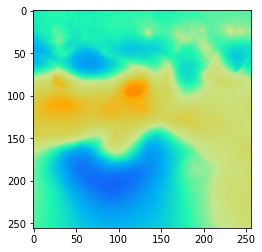

In [144]:
get_map_for_city()

## Concatenating the Threads

                      Delhi                       
inserted_ids:  600f778446cb4e5f43b0b8dc 



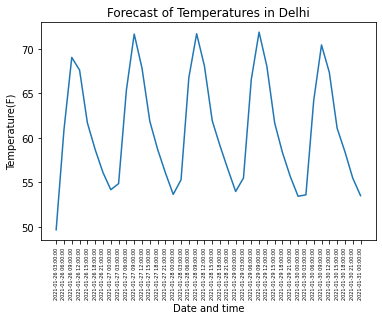

                      London                      
inserted_ids:  600f778446cb4e5f43b0b8dd 

Forecast for London is observed to be Rain on 2021-01-26 18:00:00
Forecast for London is observed to be Rain on 2021-01-26 21:00:00
Forecast for London is observed to be Rain on 2021-01-27 00:00:00
Forecast for London is observed to be Rain on 2021-01-27 09:00:00
Forecast for London is observed to be Rain on 2021-01-27 12:00:00
Forecast for London is observed to be Rain on 2021-01-27 21:00:00
Forecast for London is observed to be Rain on 2021-01-28 00:00:00
Forecast for London is observed to be Rain on 2021-01-28 03:00:00
Forecast for London is observed to be Rain on 2021-01-28 06:00:00
Forecast for London is observed to be Rain on 2021-01-28 21:00:00
Forecast for London is observed to be Rain on 2021-01-29 00:00:00
Forecast for London is observed to be Rain on 2021-01-29 12:00:00
Forecast for London is observed to be Rain on 2021-01-30 00:00:00
Forecast for London is observed to be Rain on 202

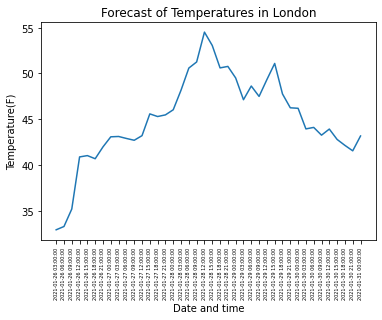

                       Utah                       
inserted_ids:  600f778546cb4e5f43b0b8de 



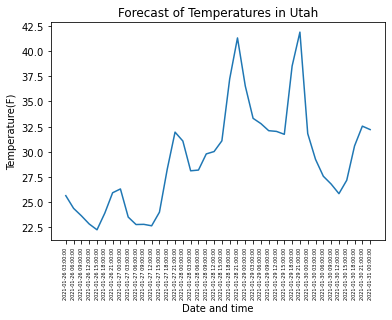

Done!


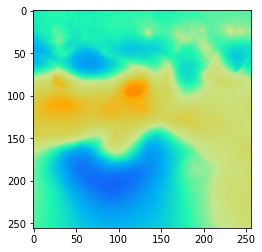

In [145]:
if __name__ == "__main__":
    
     # creating thread 
    t1 = threading.Thread(target=download_5_day_forecast) 
    t2 = threading.Thread(target=get_map_for_city) 
  
    # starting thread 1 
    t1.start() 
    t1.join()
    # starting thread 2 
    t2.start() 
    t2.join() 

  
    # wait until thread 1 is completely executed 
    # wait until thread 2 is completely executed 
  
    # both threads completely executed 
    print("Done!") 